In [1]:
import numpy as np
import pandas as pd
from pprint import pprint as pp
import json, os, sys, random, datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
random.seed(0)
from time import sleep
%matplotlib inline

/usr/local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


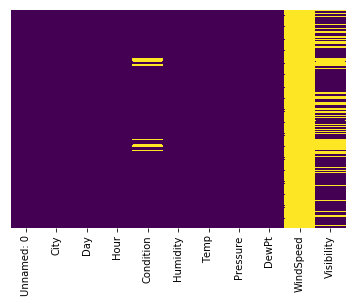

In [2]:
# load data 
df = pd.read_csv('training_data/input_data_oct.csv')

# check for nulls
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

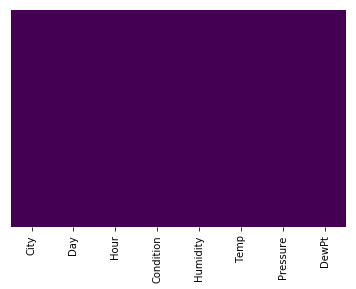

In [3]:
# cleanup and format data

# remove last two features with so many nulls
df = df.iloc[:,1:-2]

# drop rows with nulls
df = df.dropna(axis=0,how='any')


# sanity check for data
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')


# change the datatype
df[['Day','Hour','Humidity']] = df[['Day','Hour','Humidity']].astype(int)
df[['Temp','DewPt','Pressure']] = df[['Temp','DewPt','Pressure']].astype(float)


# rename column
df.rename(columns={'City': 'Location','Day':'Date'}, inplace=True)


# insert position columns for cities
df.insert(1, 'Position', '')

GEOGRAPHICAL_DATA = { 
'Sydney': [-33.86,151.20,19],
'Melbourne': [-37.66,144.84,124],
'Brisbane': [-27.47,153.02,28],
'Gold_Coast': [-28.01,153.42,3.9],
'Adelaide': [-34.92,138.59,44.7],
'Darwin': [-12.46,130.84,37],
'Wollongong': [-34.42,150.89,19],
'Canberra': [-35.28,149.12,576.7],
'Newcastle': [-32.92,151.77,12.81],
'Hobart': [-42.83,147.50,6]
}

# populate data in the position coloumn 
df['Position'] = [GEOGRAPHICAL_DATA[city]  for city in df['Location']]



In [4]:
# simplify the weathers to rain, cloudy, and clear

weather_conditions= { 
    'Rain' : ['Light Rain',
              'Light Rain Showers',
              'Light Drizzle',
              'Light Thunderstorms and Rain',
              'Heavy Rain Showers',
              'Unknown Precipitation',
              'Thunderstorms and Rain',
              'Rain',
              'Rain Showers',
              'Thunderstorm',
              'Heavy Thunderstorms and Rain',
              'Heavy Rain',
              'Drizzle',
              'Heavy Drizzle'],
    'Cloudy':['Mostly Cloudy',
              'Partly Cloudy',
              'Overcast',
              'Scattered Clouds'
             ],
    'Clear':['Clear'],
    'Snow':['Snow']
}

def simplify(cond):
    if cond in weather_conditions['Rain']:
        cond = 'Rain'
    elif cond in weather_conditions['Clear']:
        cond = 'Clear'
    elif cond in weather_conditions['Snow']:
        cond = 'Snow'
    elif cond in weather_conditions['Cloudy']:
        cond = 'Cloudy'
    else:
        cond = 'Unknown'
    return cond

df['Condition'] = df['Condition'].apply(simplify)
df = df[df['Condition'] != 'Unknown']

In [5]:
# rearrange the columns
df = df[['Date','Hour','Location','Position','Condition','Pressure','Temp','Humidity','DewPt']]

# sort by location,data and hour
df = df.sort_values(['Location','Date','Hour'])


In [6]:
# generate LocalTime Column from day and hour
tmp = pd.DataFrame(
    {
        'Time':['{:02}:{:02}:{:02}'.format(hr,random.randint(0,60),random.randint(0,60)) for hr in df['Hour'] ],
        'Date':['2017-11-{:02}'.format(day) for day in df['Date']]
    })

df.insert(4,'LocalTime','')
df['LocalTime'] = tmp['Date'] + ' ' + tmp['Time']


In [7]:
# To feed sklearn I have to convert the 'conditions' text data to a numeric value
labels = {}

for label, condition in enumerate( df['Condition'].unique() ):
    labels[condition] = label

df['label'] = df['Condition'].apply(lambda c: labels.get(c))

# handy map to refer back to the condition
label_map = { v:k for k,v in labels.items() }


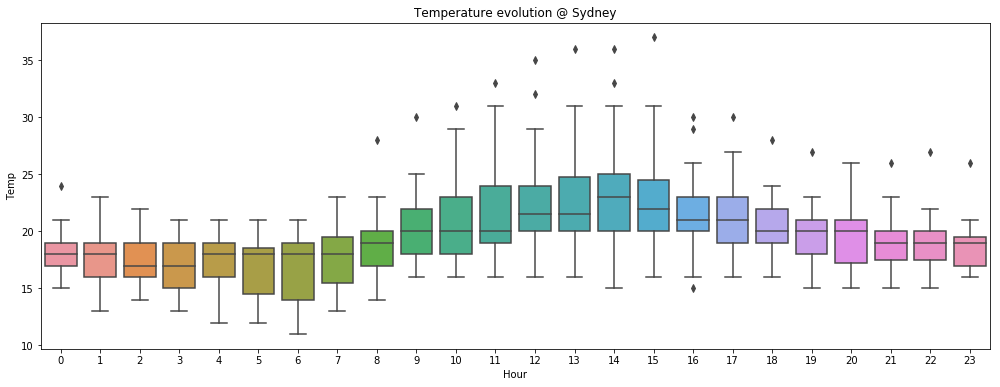

In [8]:
# variation/range of temp in syndey each hour during the day

idx = (df['Location'] == 'Sydney')
plt.figure(figsize=[17,6])
sns.boxplot(data=df[idx], x='Hour', y='Temp')
plt.title('Temperature evolution @ Sydney')
plt.show()


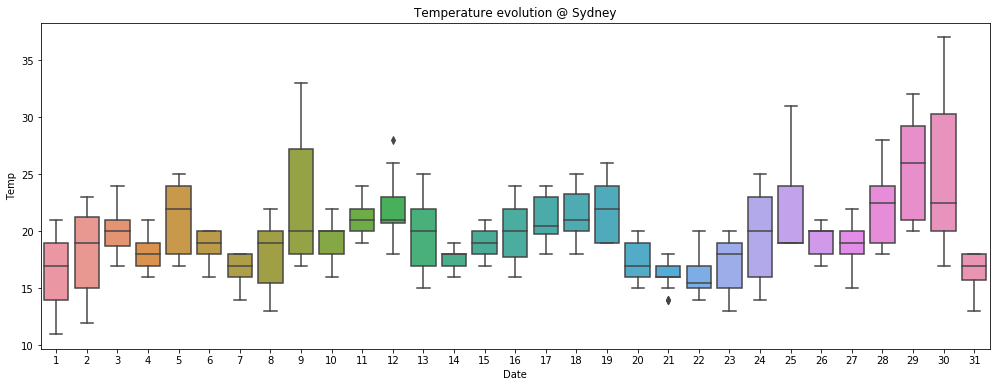

In [9]:
# variation/range of temp in syndey during the month
idx = (df['Location'] == 'Sydney')
plt.figure(figsize=[17,6])
sns.boxplot(data=df[idx], x='Date', y='Temp')
plt.title('Temperature evolution @ Sydney')
plt.show()

In [10]:
# Learning algorithm 
def learn(trainingData, features_to_drop):


    # trainingY = pd.get_dummies(trainingData['Condition'], 'Condition')
    trainingY = trainingData['label']

    trainingData.drop(features_to_drop, axis=1, inplace=True)

    # Split my data into train and test to avoid overfiting
    X_train, X_test, Y_train, Y_test = train_test_split(trainingData, trainingY)

    #  I will train a Support Vector Machine classifier
    #     note: I tried with a Logistic Regression but I only got 68% accuracy

    classifier = SVC()
    # classifier = SVC(kernel='rbf', verbose=True)
#     classifier = SVC(kernel='poly',degree=2)
    # classifier = LogisticRegression(C=1e5)
    # classifier = KNeighborsClassifier()
    classifier.fit(X=X_train, y=Y_train)

    # Now I'll check the accuracy of my model
    train_ac = classifier.score(X=X_train, y=Y_train)
    test_ac = classifier.score(X=X_test, y=Y_test)
    print('Training accuracy: {}   -  Testing accuracy: {} '.format(train_ac,test_ac))
    
    return classifier


In [11]:
# data set with all features
df.head()

,Date,Hour,Location,Position,LocalTime,Condition,Pressure,Temp,Humidity,DewPt,label
2465,1,0,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-21 06:11:43,Cloudy,1026.0,10.0,87,8.0,0
2466,1,1,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-21 07:53:22,Cloudy,1026.0,9.0,82,6.0,0
2467,1,3,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-21 08:27:54,Cloudy,1025.0,8.0,87,6.0,0
2468,1,4,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-21 09:27:26,Cloudy,1025.0,8.0,87,6.0,0
2469,1,5,Adelaide,"[-34.92, 138.59, 44.7]",2017-11-21 10:23:37,Cloudy,1025.0,8.0,81,5.0,0


In [12]:
# Drop unnecessary features
features_to_drop = ['Location','Position','LocalTime','Condition','DewPt','label']
dff = df.copy()
dff.drop(features_to_drop, axis=1, inplace=True)

# dataset with selected features
dff.head()

,Date,Hour,Pressure,Temp,Humidity
2465,1,0,1026.0,10.0,87
2466,1,1,1026.0,9.0,82
2467,1,3,1025.0,8.0,87
2468,1,4,1025.0,8.0,87
2469,1,5,1025.0,8.0,81


In [13]:
# create a predictor for each city and maintain in a dict to use it later for generating data
city_predictor = { }
city_stats_meta = {}
for city in df['Location'].unique():
    trainingData = df[ df['Location'] == city ].copy()
    
    print('City: {} '.format(city))
    classifier = learn(trainingData,features_to_drop)
    city_predictor.update({city:classifier})
    
    
    statistics = trainingData.describe()
    mean = [
        statistics['Pressure']['mean'],
        statistics['Temp']['mean'],
        statistics['Humidity']['mean']]
    covariance = statistics[['Pressure','Temp','Humidity']].cov()
    city_stats_meta.update({city:[mean,covariance]})
    
    weather_generator = np.random.multivariate_normal
    

City: Adelaide 
Training accuracy: 0.9908424908424909   -  Testing accuracy: 0.7197802197802198 
City: Brisbane 
Training accuracy: 1.0   -  Testing accuracy: 0.6785714285714286 
City: Canberra 
Training accuracy: 0.9930555555555556   -  Testing accuracy: 0.7013888888888888 
City: Darwin 
Training accuracy: 0.936046511627907   -  Testing accuracy: 0.7558139534883721 
City: Gold_Coast 
Training accuracy: 0.9787878787878788   -  Testing accuracy: 0.8288288288288288 
City: Hobart 
Training accuracy: 0.9757009345794393   -  Testing accuracy: 0.7318435754189944 
City: Melbourne 
Training accuracy: 0.9799270072992701   -  Testing accuracy: 0.726775956284153 
City: Newcastle 
Training accuracy: 0.9815303430079155   -  Testing accuracy: 0.7716535433070866 
City: Sydney 
Training accuracy: 0.970856102003643   -  Testing accuracy: 0.7065217391304348 
City: Wollongong 
Training accuracy: 1.0   -  Testing accuracy: 0.7962962962962963 


In [14]:
# sample
predicted_value = city_predictor['Adelaide'].predict([[0,0,0,0,0]])[0]
label_map[predicted_value]

'Cloudy'

In [15]:

weather_generator = np.random.multivariate_normal
city_list = [each_city for each_city in GEOGRAPHICAL_DATA.keys()]

for each in range(1,10):
    city = np.random.choice(city_list)
    city = 'Sydney'
    generated_values = weather_generator(*city_stats_meta[city]).tolist()
    # print(generated_values)
    # adding day and time to generated weather data, to predict the condition
    
    day,hour = '{:%d %H}'.format(datetime.datetime.now()).split(' ')
    day,hour = int(day),int(hour)
#     fakedatetime = fake.date_time_between(start_date="-30y", end_date="now", tzinfo=None)
#     fakedatetime = fake.future_datetime(end_date="+30d", tzinfo=None)
#     day,hour = fakedatetime.day,fakedatetime.hour  
    generated_values = [day,hour]+generated_values

    predicted_value = city_predictor[city].predict([generated_values])[0]

    Condition = label_map[predicted_value]
    Temp = generated_values[2]
    Pressure = generated_values[3]
    Humidity = generated_values[4]
#     LocalTime = fakedatetime.isoformat()
#     LocalTime ='{}Z'.format(datetime.datetime.now().isoformat()[:-4])
    Localtime= '{:%Y-%m-%dT%H:%M:%SZ}'.format(datetime.datetime.now())
    Position = GEOGRAPHICAL_DATA[city]

    output_dict = {
    'city':city,
    'lat':Position[0],
    'long':Position[1],
    'elevation':Position[2],
    'localtime':Localtime,
    'condition':Condition,
    'temp':Temp,
    'pressure':Pressure,
    'humidity':Humidity
    }
    output_string = '{city}|{lat},{long},{elevation}|{localtime}|{condition}|+{temp:.01f}|{pressure:.01f}|{humidity:.0f}'.format(**output_dict)
    sleep(0.2)
    print(output_string)


Sydney|-33.86,151.2,19|2017-12-09T23:23:25Z|Cloudy|+898.5|-4.1|33
Sydney|-33.86,151.2,19|2017-12-09T23:23:26Z|Cloudy|+628.9|-121.6|-107
Sydney|-33.86,151.2,19|2017-12-09T23:23:26Z|Cloudy|+1466.5|211.8|268
Sydney|-33.86,151.2,19|2017-12-09T23:23:26Z|Cloudy|+469.2|-163.3|-160
Sydney|-33.86,151.2,19|2017-12-09T23:23:26Z|Cloudy|+962.4|0.0|58
Sydney|-33.86,151.2,19|2017-12-09T23:23:26Z|Cloudy|+872.5|-71.0|-10
Sydney|-33.86,151.2,19|2017-12-09T23:23:27Z|Cloudy|+990.8|-381.0|-321
Sydney|-33.86,151.2,19|2017-12-09T23:23:27Z|Cloudy|+959.8|616.7|655
Sydney|-33.86,151.2,19|2017-12-09T23:23:27Z|Cloudy|+1137.2|-155.2|-90


In [17]:
datetime.datetime.now().day

10